In [57]:
# Usei como base esse tutorial:
# https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/pt-br/tutorials/keras/regression.ipynb#scrollTo=f-OHX4DiXd8x


# Ja li tudo
# https://boostedml.com/2020/04/1-d-convolutional-neural-networks-for-time-series-basic-intuition.html

# How do I use make a convolutional layer for tabular (1-D) features?
# https://stackoverflow.com/questions/59756806/tensorflow-how-do-i-use-make-a-convolutional-layer-for-tabular-1-d-features

# TODO: Fiquei de verificar:
# https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/

<IPython.core.display.Javascript object>

In [58]:
# # # # Clear logs
# # # %rm -rf ./logs/

# # # Ativação do Tensorboard
# %conda activate pystock
# %load_ext tensorboard

# # # Reload Tensorboar
# %reload_ext tensorboard

<IPython.core.display.Javascript object>

In [59]:
# # # Reload Tensorboar
# %reload_ext tensorboa

<IPython.core.display.Javascript object>

In [60]:
%load_ext nb_black
%load_ext lab_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black
The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


<IPython.core.display.Javascript object>

# Sequential model

*Dense model 16*
*Dense model 16*
*Dense model 8*
*Dense model 4*
*Epoch 350*

_MSE: 1.31_
epoch: 350

Activation: softplus
Optimizer: Adam

15/15 - 0s - loss: 0.6325 - mae: 0.5830 - mse: 0.6325
Testing set Mean Abs Error:  0.58 ibova_0

In [1]:
import pathlib
import datetime

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
import datetime

from tensorflow import keras
from tensorflow.keras import layers

from keras.callbacks import ModelCheckpoint
import keras_tuner as kt

# Lendo Dfs

In [2]:
# 60%
PATH_TREINO = "../Data/3_Gold/Treino_all_stocks.csv"
DF_TREINO = pd.read_csv(PATH_TREINO, sep=",")
train_dataset = DF_TREINO
train_dataset = train_dataset.drop(
    [
        "oil_5",
        "usd_5",
        "abev_5",
        "jbs_5",
        "petr_5",
        "vale_5",
    ],
    axis=1,
)
train_labels = train_dataset.pop("ibova_5")

# 20%
PATH_VALIDACAO = "../Data/3_Gold/Validacao_all_stocks.csv"
DF_VALIDACAO = pd.read_csv(PATH_VALIDACAO, sep=",")
valid_dataset = DF_VALIDACAO
valid_dataset = valid_dataset.drop(
    [
        "ibova_5",
        "oil_5",
        "usd_5",
        "abev_5",
        "jbs_5",
        "petr_5",
        "vale_5",
    ],
    axis=1,
)
# valid_labels = valid_dataset.pop('ibova_5')

# 20%
PATH_TESTE = "../Data/3_Gold/Teste_all_stocks.csv"
DF_TESTE = pd.read_csv(PATH_TESTE, sep=",")
test_dataset = DF_TESTE
test_dataset = test_dataset.drop(
    [
        "oil_5",
        "usd_5",
        "abev_5",
        "jbs_5",
        "petr_5",
        "vale_5",
    ],
    axis=1,
)
test_labels = test_dataset.pop("ibova_5")

In [3]:
# Tentando criar um conjunti de validação pra input no modelo

# val_dataset = tf.data.Dataset.from_tensor_slices(('ibova_0', '*'))

# valid_dataset.ibova_0

# Pesquisar:
# 	varias colunas to series em pandas

In [4]:
# index,
# ibova_0,ibova_1,ibova_2,ibova_3,ibova_4,ibova_5,
# oil_0,oil_1,oil_2,oil_3,oil_4,oil_5,usd_0,
# usd_1,usd_2,usd_3,usd_4,usd_5,
# abev_0,abev_1,abev_2,abev_3,abev_4,abev_5,
# jbs_0,jbs_1,jbs_2,jbs_3,jbs_4,jbs_5,
# petr_0,petr_1,petr_2,petr_3,petr_4,petr_5,
# vale_0,vale_1,vale_2,vale_3,vale_4,vale_5

# Inspecionando os dados

In [5]:
# sns.pairplot(train_dataset[['index','ibova_0','ibova_1','ibova_2','ibova_3','ibova_4','oil_0','oil_1','oil_2','oil_3','oil_4','usd_0','usd_1','usd_2','usd_3','usd_4']], diag_kind="kde")
# sns.pairplot(train_dataset[['index','ibova_0','oil_0','usd_0']], diag_kind="kde")
# sns.pairplot(train_dataset[['ibova_1','oil_1','usd_1']], diag_kind="kde")

train_stats = train_dataset.describe()
# train_stats

# Definindo o modelo

In [6]:
def model_builder(hp):
    hp_filter_1 = hp.Int("n_filter_1", min_value=4, max_value=16, step=1)
    hp_kernel_size_1 = hp.Int("kernel_size_1", min_value=1, max_value=15, step=2) #precisa ser impar
    
    activationL = [
        "relu",
        # "sigmoid",
        # "softplus",
        # "softsign",
        # "tanh",
        "selu",
        "elu",
        "exponential",
    ]
    activation_choice = hp.Choice("activation", values=activationL)
    hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])

    model = keras.Sequential(
        [
            tf.keras.layers.Conv1D(
                input_shape=[len(train_dataset.keys()), 1],
                filters=hp_filter_1,
                kernel_size=hp_kernel_size_1,
                activation=activation_choice, #overkill - relu ou elu 
            ),
            tf.keras.layers.Flatten(),
            # tf.keras.layers.Pooling(),
            # tf.keras.layers.GlobalAvegarePolling(),
            # tf.keras.layers.GlobalMaxPolling(), # reduz a quantidade de pesos
            # https://keras.io/api/layers/pooling_layers/global_max_pooling1d/
            tf.keras.layers.Dense(units=1, activation="linear"),
        ]
    )

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss="mse",
        metrics=["mae", "mse"],
    )

    return model


# rmse pra avaliação, nao para loss

# Instanciando Tuner

https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/keras_tuner.ipynb#scrollTo=McO82AXOuxXh

In [68]:
# early_stop = keras.callbacks.EarlyStopping(
#   monitor='val_mse', patience=50, mode='min' ,restore_best_weights=True)


# history = tuner.search(
#     train_dataset,
#     train_labels,
#     epochs=EPOCHS,
#     validation_split=0.2,
#     verbose=0,
#     # callbacks=([model_checkpoint]),
# )

# Get the optimal hyperparameters

<IPython.core.display.Javascript object>

In [69]:
tuner = kt.Hyperband(
    model_builder,
    objective="val_mse",
    max_epochs=10,
    factor=3,
    directory="logs",
    project_name="hyper_parameters",
)

INFO:tensorflow:Reloading Oracle from existing project logs\hyper_parameters\oracle.json
INFO:tensorflow:Reloading Tuner from logs\hyper_parameters\tuner0.json


<IPython.core.display.Javascript object>

# Selecionando a melhor epoca do modelo

In [70]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
save_time = datetime.datetime.strftime(datetime.datetime.now(), "%y_%m_%d_%Hh%Mm%S")

bst_model_path = f"Models/CNN/model_{save_time}.h5"
model_checkpoint = ModelCheckpoint(
    bst_model_path, save_best_only=True, monitor="val_mse", mode="min"
)

EPOCHS = 500

best_hps = tuner.get_best_hyperparameters(num_trials=20)[0]


model = tuner.hypermodel.build(best_hps)
history = model.fit(
    train_dataset,
    train_labels,
    epochs=EPOCHS,
    validation_split=0.2,
    verbose=0,
    callbacks=([model_checkpoint]),
)

# Select the best epoch,
val_mse_per_epoch = history.history["val_mse"]
best_epoch = val_mse_per_epoch.index(min(val_mse_per_epoch)) + 1

print("Best epoch: %d" % (best_epoch,))
print(f'val_mae: {min(history.history["val_mae"])}')
print(f'val_mse: {min(history.history["val_mse"])}')

Best epoch: 257
val_mae: 0.20692229270935059
val_mse: 0.06966464966535568


<IPython.core.display.Javascript object>

In [71]:
print(f'n_filter_1: {best_hps.get("n_filter_1")}')
print(f'n_filter_2: {best_hps.get("n_filter_2")}')
print(f'kernel_size_1: {best_hps.get("kernel_size_1")}')
print(f'kernel_size_2: {best_hps.get("kernel_size_2")}')

# print(f'unit_3: {best_hps.get("unit_3")}')
# print(f'unit_4: {best_hps.get("unit_4")}')
print(f'learning_rate: {best_hps.get("learning_rate")}')
print(f'activation: {best_hps.get("activation")}')

n_filter_1: 4
n_filter_2: 4
kernel_size_1: 4
kernel_size_2: 4
learning_rate: 0.01
activation: elu


<IPython.core.display.Javascript object>

In [72]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 33, 4)             20        
                                                                 
 flatten_5 (Flatten)         (None, 132)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 133       
                                                                 
Total params: 153
Trainable params: 153
Non-trainable params: 0
_________________________________________________________________


<IPython.core.display.Javascript object>

# Treinando modelo

In [73]:
# hypermodel = tuner.hypermodel.build(best_hps)
# history = hypermodel.fit(train_dataset, train_labels, epochs=best_epoch, validation_split=0.2, verbose=1)

# # ja pega o modelo na melhor epoca

<IPython.core.display.Javascript object>

In [74]:
eval_result = model.evaluate(test_dataset, test_labels)
print("[test loss, test accuracy]:", eval_result)

15/15 [==============================] - 0s 3ms/step - loss: 0.1187 - mae: 0.2073 - mse: 0.1187
[test loss, test accuracy]: [0.11872777342796326, 0.20732051134109497, 0.11872777342796326]


<IPython.core.display.Javascript object>

# Avaliando o modelo

In [75]:
# print(f'train_dataset: {train_dataset.columns()} \n')
# print(f'valid_dataset: {valid_dataset.columns()} \n')
# print(f'test_dataset: {test_dataset.columns()} \n')

<IPython.core.display.Javascript object>

In [76]:
hist = pd.DataFrame(history.history)
hist["epoch"] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
495,0.051492,0.175653,0.051492,0.078732,0.216699,0.078732,495
496,0.050492,0.171517,0.050492,0.092949,0.241336,0.092949,496
497,0.050351,0.173125,0.050351,0.083725,0.226078,0.083725,497
498,0.051727,0.175029,0.051727,0.074549,0.214421,0.074549,498
499,0.050914,0.173718,0.050914,0.076294,0.215541,0.076294,499


<IPython.core.display.Javascript object>

In [77]:
print(f"Min MSE: {hist.mse.min()}")
print(f"Min Val_MSE: {hist.val_mse.min()}")

Min MSE: 0.04892938211560249
Min Val_MSE: 0.06966464966535568


<IPython.core.display.Javascript object>

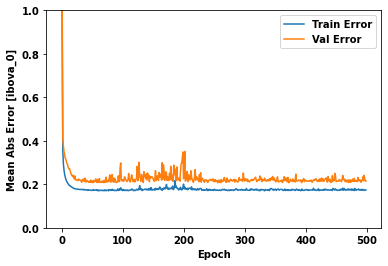

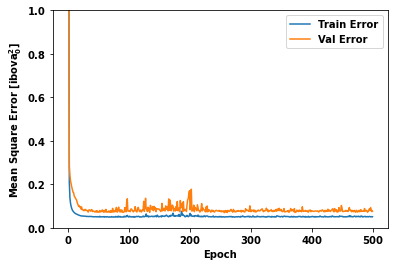

<IPython.core.display.Javascript object>

In [78]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist["epoch"] = history.epoch

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Abs Error [ibova_0]")
    plt.plot(hist["epoch"], hist["mae"], label="Train Error")
    plt.plot(hist["epoch"], hist["val_mae"], label="Val Error")
    plt.ylim([0, 1])
    plt.legend()

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Square Error [$ibova_0^2$]")
    plt.plot(hist["epoch"], hist["mse"], label="Train Error")
    plt.plot(hist["epoch"], hist["val_mse"], label="Val Error")
    plt.ylim([0, 1])
    plt.legend()
    plt.show()


plot_history(history)

# Realizando as previsões

In [79]:
test_predictions = model.predict(test_dataset).flatten()

15/15 [==============================] - 0s 4ms/step


<IPython.core.display.Javascript object>

# Avaliando as previsões:

In [80]:
def show_test_labels():
    # Imprimindo valores reais
    plt.plot(test_labels, color="r", label="ibova_REAL")
    plt.xlabel("Dates")
    plt.ylabel("Variation ROC")
    plt.title("ibova_REAL")
    plt.legend()


def show_model_predictions():
    # Imprimindo previsoes
    plt.plot(test_predictions, color="g", label="predictions_MODEL")
    plt.xlabel("Dates")
    plt.ylabel("Variation ROC")
    plt.title("predictions_MODEL")
    plt.legend()


def show_compare_graph():
    # Predictt X Real values
    plt.plot(test_labels, color="r", label="ibova_REAL")
    plt.plot(test_predictions, color="g", label="predictions_MODEL")
    plt.xlabel("Dates")
    plt.ylabel("Variation ROC")
    plt.title("Predict X Real values")
    plt.legend()
    plt.show()


def show_true_predict_values():
    plt.figure(figsize=(24, 4))
    plt.scatter(test_labels, test_predictions)
    plt.xlabel("True Values [ibova_0]")
    plt.ylabel("Predictions [ibova_0]")
    plt.axis("equal")
    plt.axis("square")
    plt.xlim([0, plt.xlim()[1]])
    plt.ylim([0, plt.ylim()[1]])
    _ = plt.plot([-100, 100], [-100, 100])

<IPython.core.display.Javascript object>

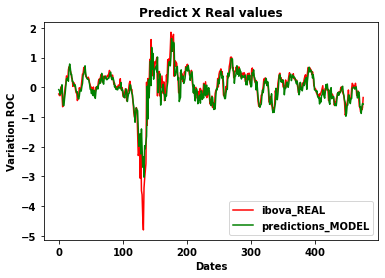

<IPython.core.display.Javascript object>

In [81]:
show_compare_graph()

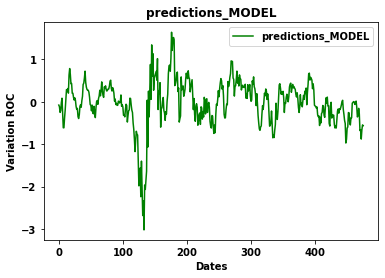

<IPython.core.display.Javascript object>

In [82]:
show_model_predictions()

In [83]:
model_name = f'mlp_unit_1({best_hps.get("unit_1")})unit_2({best_hps.get("unit_2")})unit_3({best_hps.get("unit_3")})unit_4({best_hps.get("unit_4")})_learning({best_hps.get("learning_rate")})_activation({best_hps.get("activation")})'
model_name
model.save(f"models/mlp/{model_name}date_{save_time}.h5")

<IPython.core.display.Javascript object>

In [84]:
# Analisando Medias:

print(f"Massa de predição: {test_predictions.mean()}")
print(f"Massa inicial: {ibova_test.mean()}")
print(f"Diferenças das médias: {ibova_test.mean() - test_predictions.mean()}")

# Add o RM_MSE medio

Massa de predição: -0.024132050573825836


NameError: name 'ibova_test' is not defined

<IPython.core.display.Javascript object>

In [ ]:
save_time

'22_08_30_22h55m31'

<IPython.core.display.Javascript object>